In [ ]:
# [[30, 4, 5]] From Ye Delfosse long chain [2503.22071]

# Params from table II:
# l = 5
# m = 3
# A = x^0 + x 
# B = x^0 + y + x^2*y^2  


# I(A) = {0, 1} -- exponents of x in A
# J(A) = {0, 0} -- corresponding exponents of y in A
# I(B) = {0, 0, 2} -- exponents of x in B
# J(B) = {0, 1, 2} -- corresponding exponents of y in B

In [ ]:
import stim
from bb_ions import *


# keep track of inputs:
# n, p, 

# I(A), J(A), I(B), J(B) eventually...

n = 30
p = 0 # depolarising noise
p_idle = p/100 # idling noise (just dephasing if idleZ func used)


qL, qR, qX, _ = make_registers(n)
qZ = qX # re-using auxiliaries


c = stim.Circuit()

# Initialise qubits ( assuming |0⟩ then H to get to |+⟩ )
initZ(c, qX, p)
idleZ(c, qL + qR, p_idle) # idle data qubits (could comment out as they're about to be reset)
tick(c)

hadamard(c, qX, p)
initZ(c, qL + qR, p) # initialise data qubits
tick(c)


print(qX, qL, qR)


# X-check CNOTs
# Measure check qubits
# Add detectors
# Z-check CNOTs
# Measure check qubits
# Add detectors

[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


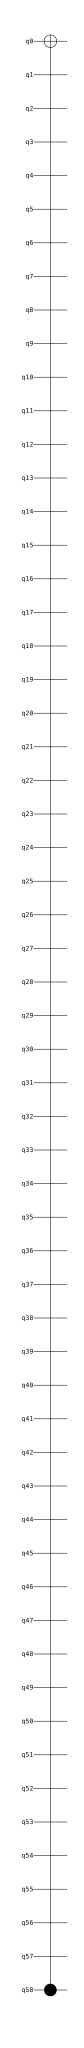

In [2]:
import stim
from bb_ions import *

l = 5
m = 3


c = stim.Circuit()

'''let 
    u = 0 be left data qubits
    u = 1 be right data qubits
    u = 2 be check qubits
'''
c.append("CNOT", [convtok(l, m, 3, 4, 1), convtok(l, m, 0, 0, 0)])

c.diagram("timeline-svg")

